**Examining US Auto Stocks**

In [61]:
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import pandas_datareader as pdr;
import seaborn as sns;

In [11]:
# Create pandas DataFrame for the stock prices - using a lookback period of ~5 years since I believe this is 
# enough time to find any present relationships while reducing computational requirements. 

Tickers = ['F','GM','TSLA']

stockPrices = pdr.get_data_yahoo(Tickers,start='2015-01-01')['Close']

In [60]:
stockPrices.head()

Symbols,F,GM,TSLA
Date,,,
2015-01-02,15.36,34.840000,219.309998
2015-01-05,14.76,34.330002,210.089996
2015-01-06,14.62,34.849998,211.279999
2015-01-07,15.04,35.840000,210.949997
2015-01-08,15.42,36.200001,210.619995


Text(0.5, 1.0, 'F vs GM 5 year chart')

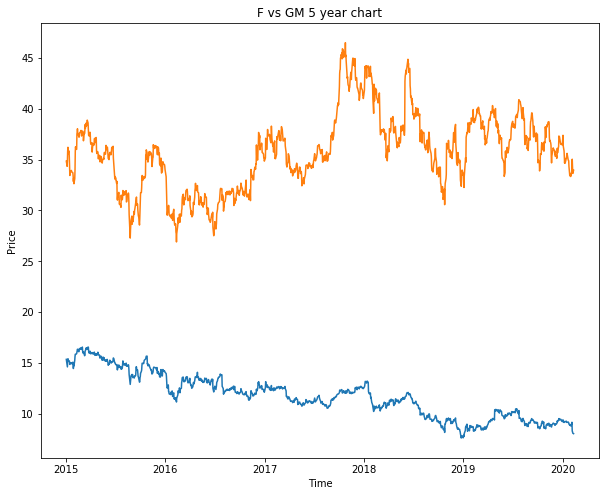

In [59]:
# Explore the prices of F and GM only
# I am only plotting these 2 prices since Tesla's price is far higher and so will completely skew the chart 

plt.figure(figsize=(10,8))
plt.plot(stockPrices.iloc[:,[0,1]])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('F vs GM 5 year chart')


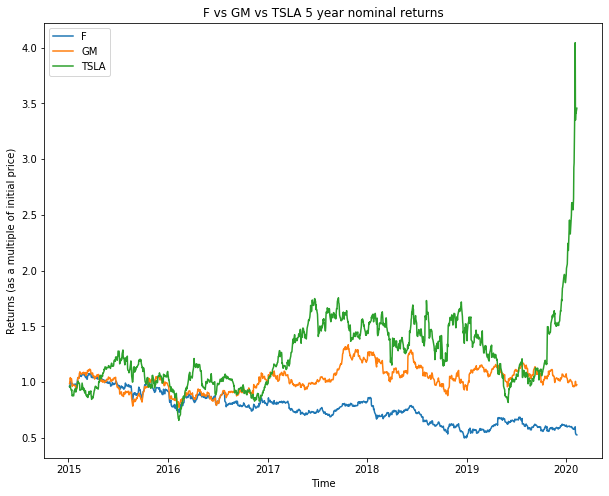

In [47]:
# Calculate a weight index to show returns for the period 

stockReturns = stockPrices.pct_change().dropna() # Creates a dataframe of returns (caveat: this will only approximate log-returns - will differ very slightly)

weightIndex = np.cumprod(1+stockReturns)

plt.figure(figsize=(10,8))
plt.plot(weightIndex)
plt.xlabel('Time')
plt.ylabel('Returns (as a multiple of initial price)')
plt.title('F vs GM vs TSLA 5 year nominal returns')
plt.legend(['F','GM','TSLA'])


In [56]:
print(
    'F nominal return: ', (weightIndex.loc[weightIndex.index[-1],'F']-1)*100,'%\n',
    'GM nominal return:', (weightIndex.loc[weightIndex.index[-1],'GM']-1)*100,'%\n',
    'TSLA nominal return:', (weightIndex.loc[weightIndex.index[-1],'TSLA']-1)*100,'%\n',
)

F nominal return:  -47.52603776190269 %
 GM nominal return: -2.568887640194606 %
 TSLA nominal return: 245.6750645320647 %



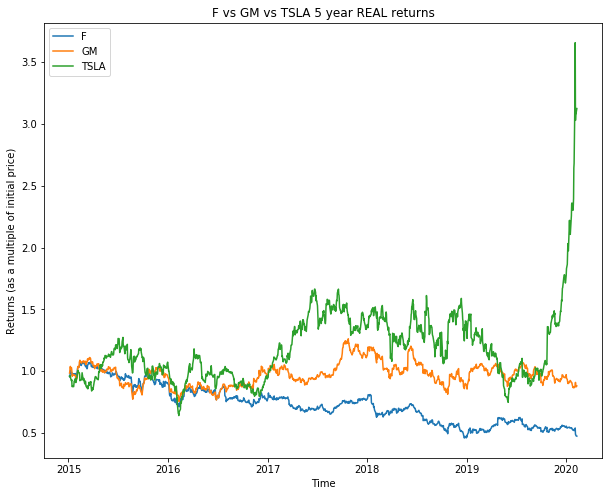

In [24]:
# Let's calculate approximate 'real' returns by subtracting for a 2% annualised loss of purchasing power 

# Calculated using i = (1 + i_252) ^ (252)

# Therefore i_252 = (i ^ (1/252)) -1

# Where i represents the annual rate and i_252 is the ~daily rate (252 since that's the rough number of trading days)

i = 1.02

i_252 = ((i)**(1/252))-1 # This is the daily loss due of purchasing power  

real_weightIndex = np.cumprod(1+(stockReturns-i_252))

plt.figure(figsize=(10,8))
plt.plot(real_weightIndex)
plt.xlabel('Time')
plt.ylabel('Returns (as a multiple of initial price)')
plt.title('F vs GM vs TSLA 5 year REAL returns')
plt.legend(['F','GM','TSLA'])


In [55]:
print(
    'F real return: ', (real_weightIndex.loc[weightIndex.index[-1],'F']-1)*100,'%\n',
    'GM real return:', (real_weightIndex.loc[weightIndex.index[-1],'GM']-1)*100,'%\n',
    'TSLA real return:', (real_weightIndex.loc[weightIndex.index[-1],'TSLA']-1)*100,'%\n',
)

F real return:  -52.565637219645176 %
 GM real return: -11.92194495644543 %
 TSLA real return: 212.51284928382304 %



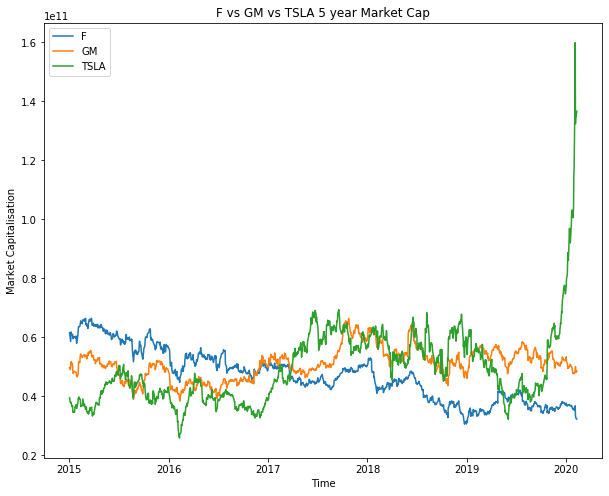

In [43]:
# Plotting market caps
# This does however use the naive assumption that current shares outstanding was the same for the entire period

sharesOutstanding = {'F':4010000000,'GM':1430000000,'TSLA':180240000}

market_cap = stockPrices * sharesOutstanding

market_cap = market_cap.astype(int)

plt.figure(figsize=(10,8))
plt.plot(market_cap)
plt.xlabel('Time')
plt.ylabel('Market Capitalisation')
plt.title('F vs GM vs TSLA 5 year Market Cap')
plt.legend(['F','GM','TSLA'])

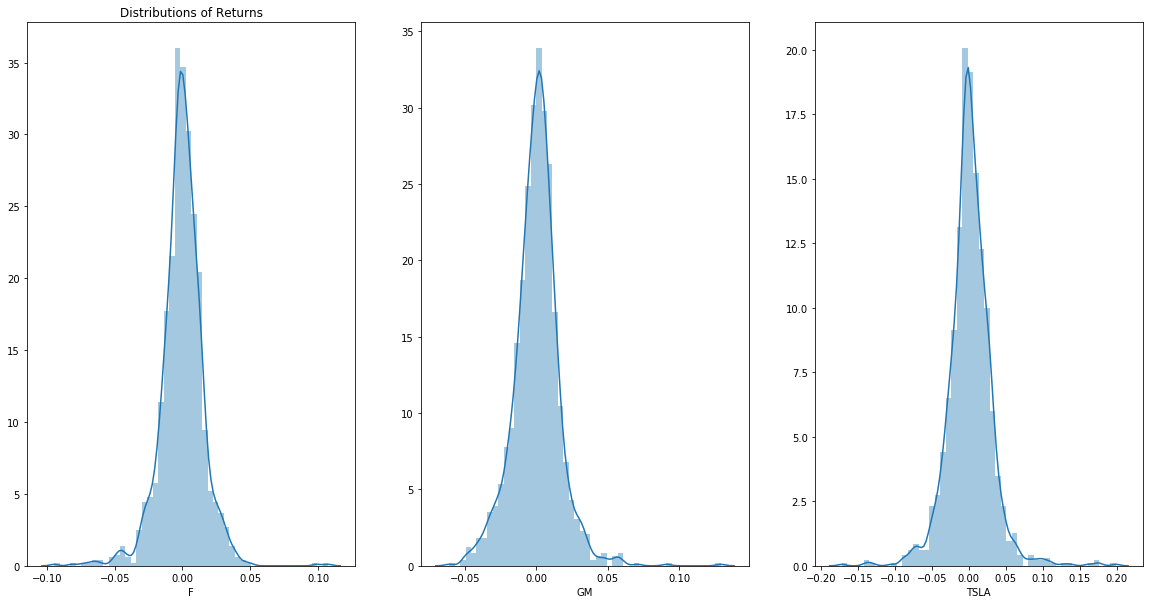

In [74]:
# Plot the distribution of returns for each of the 3 stocks

plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
sns.distplot(stockReturns['F'])
plt.title('Distributions of Returns')

plt.subplot(1, 3, 2)
sns.distplot(stockReturns['GM'])

plt.subplot(1, 3, 3)
sns.distplot(stockReturns['TSLA'])


In [75]:
# Perform tests of normality of the returns for each stock:

from scipy.stats import shapiro 

for i in Tickers:
    print('Normality test p-value for',i,shapiro(stockReturns[i])[1])

Normality test p-value for F 5.93107532836442e-23
Normality test p-value for GM 6.221304873898309e-20
Normality test p-value for TSLA 6.3462829375472955e-25


All p-values are far less than any threshold we would use therefore we will reject the null hypotheses that each stock's returns were normally distributed. 

Visually we can see that the peaks of the distributions are all far too high and the tails too long to be normal. Meaning we see far more clustering around the means (more observations around the mean) and also more extreme values occurring. 

mu= 0.001404132446314343 sigma= 0.029687055434268687


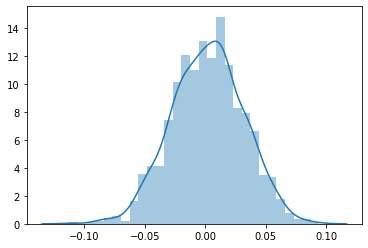

In [77]:
# Out of interest let's generate a normal distribution which we might assume Tesla's returns follow 
# using the empirical mean and standard deviation from the sample.

mu, sigma = stockReturns['TSLA'].mean(), stockReturns['TSLA'].std()

print('mu=',mu,'sigma=',sigma)

sample = np.random.normal(mu, sigma, size=len(stockReturns))

sns.distplot(sample)

Under a normal distribution with sample mean and standard deviation we would only expect to see extreme values of +/- 10% whereas in reality we observe values of +/- 20%.

That was generated by drawing n random samples from N(mu, sigma) where n is the number of empirical observations we have. Let me set n=10,000 to make further comparisons: 

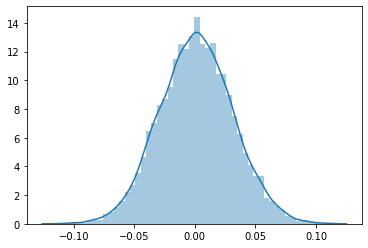

In [78]:
sample = np.random.normal(mu, sigma, size=10000)

sns.distplot(sample)

Increasing that sample size now gives a far smoother appearance to the distribution than previously. 

Next I will observere what proportion of results fall above or below 0.10: 

In [98]:
cond1 = sample > 0.1 
cond2 = sample < -0.1 

print((len(sample[cond1 | cond2])/len(sample)) * 100, '%')

cond3 = sample > 0.15
cond4 = sample < -0.15 

print((len(sample[cond3 | cond4])/len(sample)) * 100, '%')

0.13 %
0.0 %


Out of 10,000 observations only 0.13% will fall above or below 0.10 i.e. a 10% loss or gain for the day. Let us now compare that with the proportion from the _actual_ sample, albeit from a smaller number of observations. 

Additionally, testing for 0.15 we find that 0 observations fall outside the interval [-0.15,0.15]

In [99]:
cond1 = stockReturns['TSLA'] > 0.1
cond2 = stockReturns['TSLA'] < -0.1

print((len(stockReturns['TSLA'][cond1 | cond2])/len(stockReturns['TSLA'])) * 100, '%')

cond1 = stockReturns['TSLA'] > 0.15
cond2 = stockReturns['TSLA'] < -0.15

print((len(stockReturns['TSLA'][cond1 | cond2])/len(stockReturns['TSLA'])) * 100, '%')


1.1682242990654206 %
0.3894080996884735 %


In our actual sample, 1.17% of observations fall outside the interval [-0.1,0.1] and 0.39% fall outside of [-0.15,0.15].

When making these observations it's easier to see how those assumptions of the normality of returns falls short. 

Many models assume that stock prices follow normal distributions however, in the case of these 3 (admittedly a small sample size and they will all be somewhat correlated due to the same industry) the assumption is clearly invalid and underestimates the scale of potential returns.

A simple extension of what I've done above would be that we can state an approximate **Value-at-Risk** for Tesla for $a = 0.01,  a = 0.05$. 
This is essentially finding the 5% and 1% quantile for our observed returns distribution.

In [158]:
VaR5 = np.quantile(stockReturns['TSLA'],0.05)
VaR1 = np.quantile(stockReturns['TSLA'],0.01)

print(
    '5% VaR threshold:',VaR5,', 1% VaR threshold:',VaR1
)

5% VaR threshold: -0.0422988495398189 , 1% VaR threshold: -0.07631205997200899


What these values say is that based on our sample (therefore, they must be taken with a grain of salt) is that 5% of the time we can expect our 1-day loss on Tesla to exceed 4.23% and 1% of the time we can expect it to exceed 7.63%. 

Therefore, 1 out of every 100 trading days we would expect our loss to exceed 7.63%.

Then, an extension of VaR is to calculate the **Expected Shortfall** or **Condition-VaR** which is the expectation of the loss _given that the VaR threshold has been exceeded_.

$ES = E[L|L>VaR_a]$ where $VaR_a$ is the VaR value for the threshold $a$.

In [163]:
ES5 = np.mean(stockReturns['TSLA'][stockReturns['TSLA']<VaR5])
ES1 = np.mean(stockReturns['TSLA'][stockReturns['TSLA']<VaR1])

print(
    '5% Expected Shortfall:',ES5,', 1% Expected Shortfall:',ES1
)

5% Expected Shortfall: -0.06524074170894019 , 1% Expected Shortfall: -0.10423244763872998


This states that when our 5% VaR level is exceeded we would actually expect the loss to be 6.5% and for the 1% level we would expect it to be 10.4%. 

This sort of analysis is beneficial at highlighting potential worst-case scenarios. Having accurate risk measures allows investors to make better decisions pertaining to questions of leverage, etc. 

**Analysing the classic 'Pairs Trade'**

A pairs trade is a trade taken on a pair of stocks often assumed to have a high correlation due to them possessing similar characteristics or being somewhat substitutes for one another. GM and Ford are a classic example of one of these pairs so I will perform some analysis to see whether assumptions behind the idea hold true such as high correlation or convergence of returns. 

In [101]:
pairReturns = stockReturns.iloc[:,[0,1]]

pairReturns.head()

Symbols,F,GM
Date,,
2015-01-05,-0.039062,-0.014638
2015-01-06,-0.009485,0.015147
2015-01-07,0.028728,0.028408
2015-01-08,0.025266,0.010045
2015-01-09,-0.013619,-0.016851


In [148]:
rho = pairReturns['F'].corr(pairReturns['GM'])

print(
    'Correlation coefficient between F and GM returns:', rho
)

Correlation coefficient between F and GM returns: 0.6543027417357962


Now I will create a scatter plot with a line of best fit through the points. 

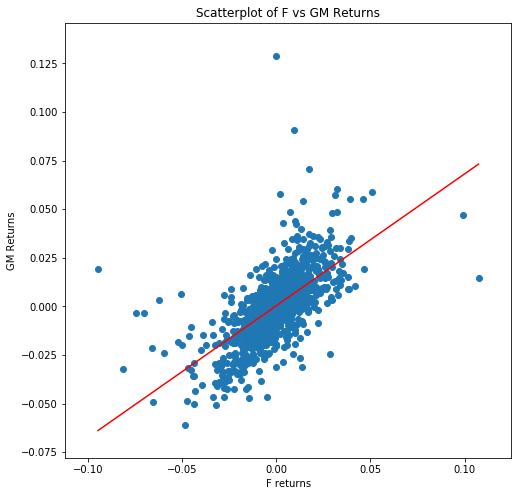

In [116]:
plt.figure(figsize=(8,8))
plt.scatter(pairReturns['F'],pairReturns['GM'])
plt.xlabel('F returns')
plt.ylabel('GM Returns')
plt.title('Scatterplot of F vs GM Returns')
plt.plot(np.unique(pairReturns['F']), np.poly1d(np.polyfit(pairReturns['F'], pairReturns['GM'], 1))(np.unique(pairReturns['F']))
         ,color='red')




The scatterplot shows a reasonable correlation - while not one that could be considered very strong it's certainly not insigificant either. 

I shall observe the rolling correlation as well since a point-estimate for the correlation coefficient like above becomes less meaningful if we observe significant variation in the correlation over time. 

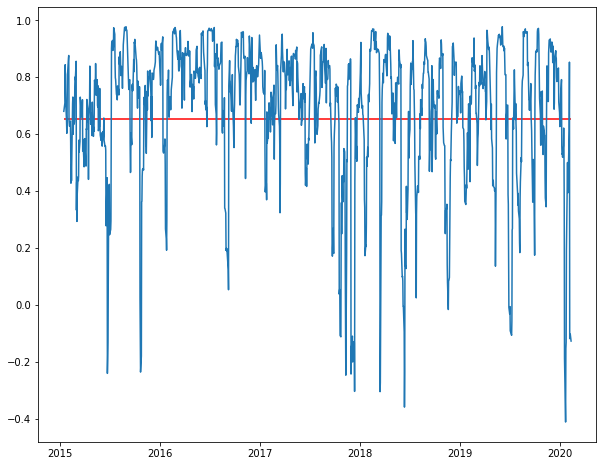

In [154]:
rolling_cor = pairReturns['F'].rolling(window=10).corr(pairReturns['GM']).dropna()

plt.figure(figsize=(10,8))
plt.plot(rolling_cor)
plt.hlines(rho,xmin=rolling_cor.index[0],xmax=rolling_cor.index[-1],color='red')

In [155]:
print(
    'Standard deviation of the correlation coefficient:',rolling_cor.std()
)

Standard deviation of the correlation coefficient: 0.24931416197263767


The rolling correlation plot shows that we observe large variation in the correlation over time however most of the observations do seem to cluster in the [0.6,0.8] interval. However, we observe a handful of extreme values even those going below 0 to indicate positive correlation. 

And the standard deviation of the parameter is 0.25. While I'm unsure on the technical requirements for parameter acceptance or something similar, it seems that this relationship is valid for the majority of the time, with extreme values e.g. negative correlation values.

I shall inspect whether the returns of F and GM come from the same distribution using a Kolmogorov-Smirnov test:

In [142]:
from scipy.stats import ks_2samp

print(
    'P-value for test of sameness of distributions:',ks_2samp(pairReturns['F'],pairReturns['GM'])[1]
)

P-value for test of sameness of distributions: 0.3560441491911021


The null hypothesis stated that these 2 samples were drawn from the same distribution. The P-value for this test is 0.356 which is greater than 0.05. Since this isn't below any thresholds (0.05, 0.01, etc) we cannot reject the null hypothesis. 

This **doesn't** necessarily mean the samples **are** from the same distribution but simply means we cannot rule out the possibility that they are. 